In [ ]:
import pandas as pd
df = pd.read_csv('maternaldata.csv')
df.head()

,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate,Risk Level
0,22,90.0,60.0,9.0,100,18.0,1.0,1.0,0,1,80.0,High
1,22,110.0,70.0,7.1,98,20.4,0.0,0.0,0,0,74.0,Low
2,27,110.0,70.0,7.5,98,23.0,1.0,0.0,0,0,72.0,Low
3,20,100.0,70.0,7.2,98,21.2,0.0,0.0,0,0,74.0,Low
4,20,90.0,60.0,7.5,98,19.7,0.0,0.0,0,0,74.0,Low


In [46]:
df.shape

(1205, 12)

In [47]:
df = df.drop_duplicates()
df.shape

(1187, 12)

No of duplicate rows =18 , duplicate rows are ommited

In [48]:
df.isnull().sum()

Age                        0
Systolic BP                5
Diastolic                  4
BS                         2
Body Temp                  0
BMI                       18
Previous Complications     2
Preexisting Diabetes       2
Gestational Diabetes       0
Mental Health              0
Heart Rate                 2
Risk Level                18
dtype: int64

In [49]:
18/1187

0.015164279696714406

we have missing data on response variable, for better modelling decided to remove those rows to get unbiased results.<br>
only 18 out of 1187 ----> 1.5%

In [50]:
df.dropna(subset=['Risk Level'], inplace=True)
df.shape

(1169, 12)

In [51]:
df.isnull().sum()

Age                        0
Systolic BP                4
Diastolic                  2
BS                         1
Body Temp                  0
BMI                       14
Previous Complications     1
Preexisting Diabetes       1
Gestational Diabetes       0
Mental Health              0
Heart Rate                 1
Risk Level                 0
dtype: int64

In [52]:
df.dtypes

Age                         int64
Systolic BP               float64
Diastolic                 float64
BS                        float64
Body Temp                   int64
BMI                       float64
Previous Complications    float64
Preexisting Diabetes      float64
Gestational Diabetes        int64
Mental Health               int64
Heart Rate                float64
Risk Level                 object
dtype: object

### Train Test Splitting

In [53]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop('Risk Level', axis=1), df['Risk Level'], test_size=0.2, random_state=42)

### Preprocessing of X_train

In [54]:
X_train.isnull().sum()

Age                        0
Systolic BP                4
Diastolic                  2
BS                         1
Body Temp                  0
BMI                       11
Previous Complications     1
Preexisting Diabetes       1
Gestational Diabetes       0
Mental Health              0
Heart Rate                 1
dtype: int64

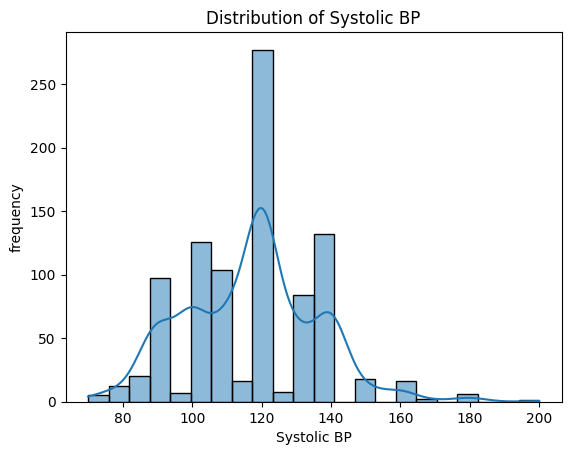

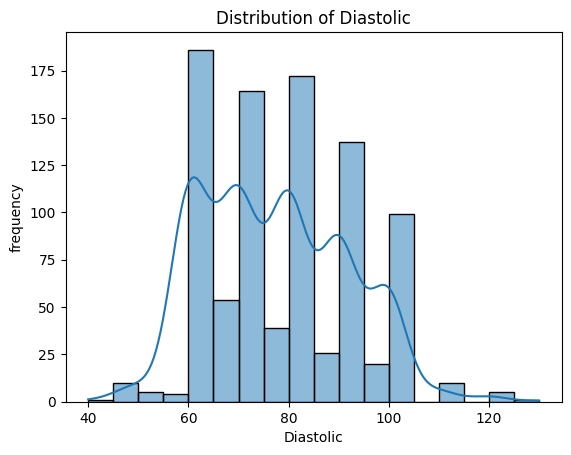

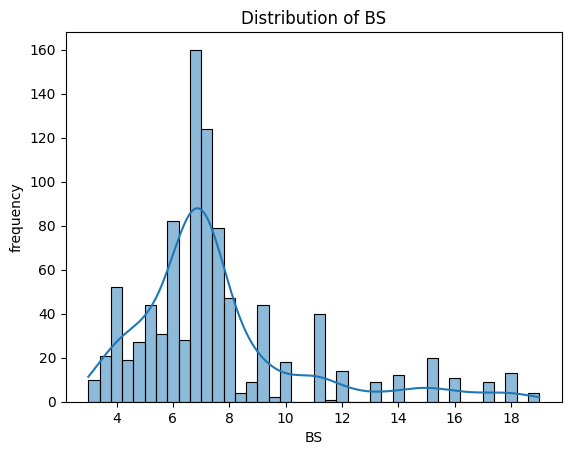

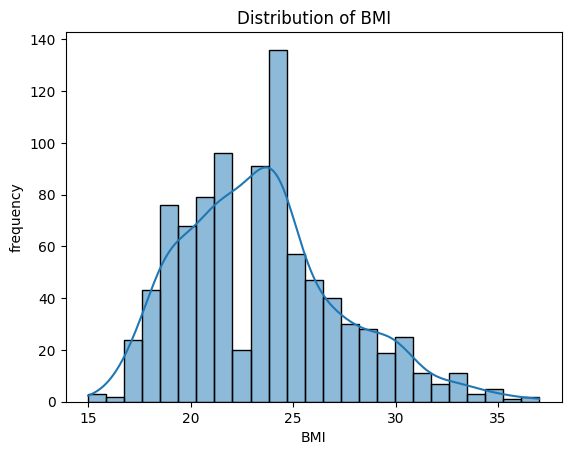

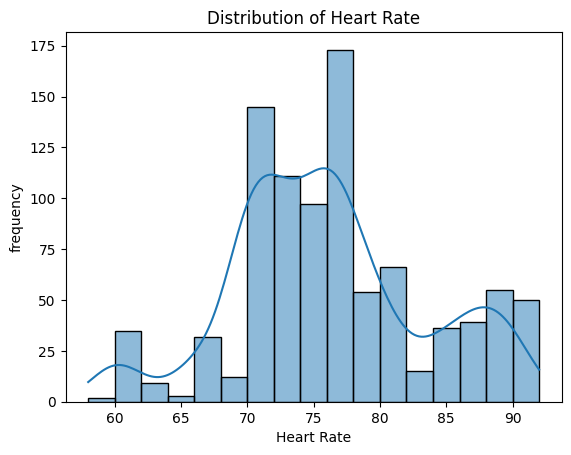

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

cols=['Systolic BP','Diastolic','BS','BMI','Heart Rate']
for i in cols:
  sns.histplot(X_train[i],kde=True)
  plt.xlabel(i)
  plt.title(f"Distribution of {i}")
  plt.ylabel("frequency")
  plt.show()

In [56]:
print(df['Previous Complications'].value_counts())
print(df['Preexisting Diabetes'].value_counts())

Previous Complications
0.0    959
1.0    209
Name: count, dtype: int64
Preexisting Diabetes
0.0    825
1.0    343
Name: count, dtype: int64


In [57]:
cols_to_fill = ['Systolic BP','Diastolic','BS','BMI','Heart Rate']
for col in cols_to_fill:
  X_train[col] = X_train[col].fillna(X_train[col].median())




In [58]:
X_train['Preexisting Diabetes'] = X_train['Preexisting Diabetes'].fillna(X_train['Preexisting Diabetes'].mode()[0])
X_train['Previous Complications'] = X_train['Previous Complications'].fillna(X_train['Previous Complications'].mode()[0])

print("Missing values in X_train after imputation:")
print(X_train.isnull().sum())

Missing values in X_train after imputation:
Age                       0
Systolic BP               0
Diastolic                 0
BS                        0
Body Temp                 0
BMI                       0
Previous Complications    0
Preexisting Diabetes      0
Gestational Diabetes      0
Mental Health             0
Heart Rate                0
dtype: int64


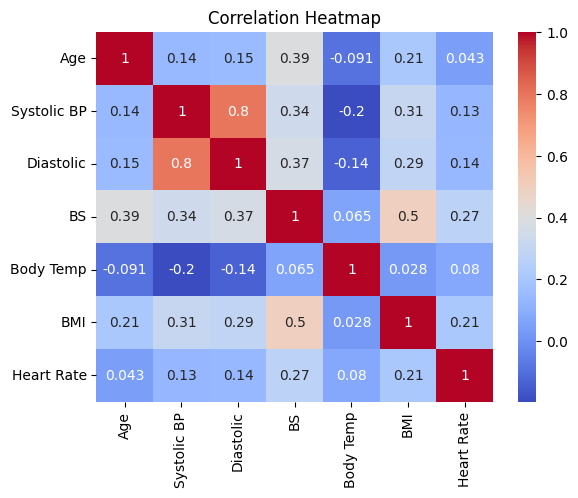

In [59]:
num_cols = ['Age','Systolic BP','Diastolic','BS','Body Temp','BMI','Heart Rate']
X_train1 = X_train[num_cols]
sns.heatmap(X_train1.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

outlier detection in numerical predictors

In [60]:
import numpy as np

def count_outliers_iqr(df, factor=1.5):
    """
    Returns a Series of outlier counts per numeric feature using IQR method.
    """
    numeric = df.select_dtypes(include=[np.number])
    counts = {}
    for col in numeric:
        Q1 = numeric[col].quantile(0.25)
        Q3 = numeric[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        mask = (numeric[col] < lower) | (numeric[col] > upper)
        counts[col] = mask.sum()
    return pd.Series(counts, name="n_outliers_iqr")

outlier_counts_iqr = count_outliers_iqr(X_train[num_cols], factor=1.5)
print(outlier_counts_iqr)


Age             50
Systolic BP      7
Diastolic        1
BS              94
Body Temp      138
BMI             30
Heart Rate       0
Name: n_outliers_iqr, dtype: int64


Factor analysis

In [61]:
cat_cols = ['Preexisting Diabetes','Previous Complications','Gestational Diabetes','Mental Health']
X_train2 = X_train[cat_cols].astype(str)
X_train2.head()

,Preexisting Diabetes,Previous Complications,Gestational Diabetes,Mental Health
598,0.0,0.0,0,0
186,1.0,0.0,0,1
762,0.0,0.0,0,0
180,0.0,0.0,1,1
604,0.0,0.0,0,0


In [62]:
X_train3 = pd.concat([X_train1,X_train2], axis=1)
X_train3.head()

,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Heart Rate,Preexisting Diabetes,Previous Complications,Gestational Diabetes,Mental Health
598,23,140.0,90.0,6.8,98,23.0,70.0,0.0,0.0,0,0
186,28,140.0,90.0,8.0,98,25.7,80.0,1.0,0.0,0,1
762,25,120.0,90.0,6.7,101,21.0,80.0,0.0,0.0,0,0
180,25,130.0,100.0,7.8,98,30.6,86.0,0.0,0.0,1,1
604,19,120.0,80.0,4.0,98,20.0,70.0,0.0,0.0,0,0


In [63]:
pip install prince

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


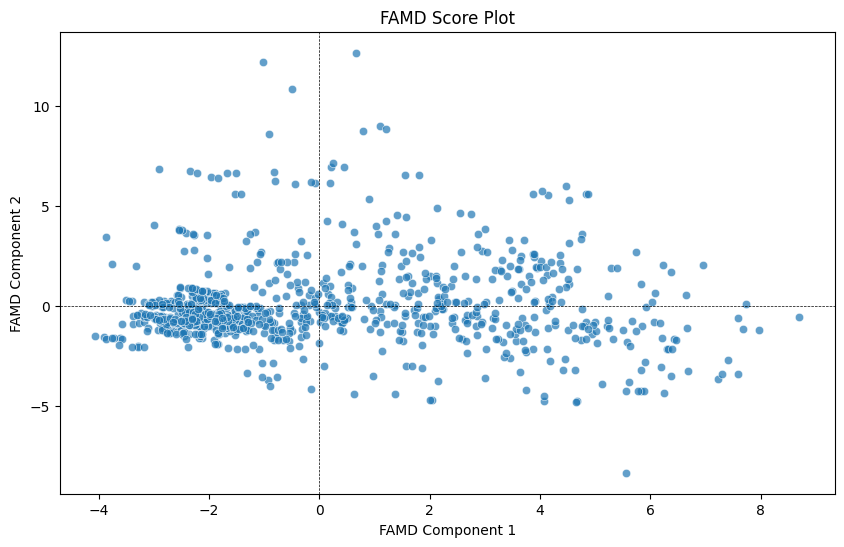

In [64]:
import prince

famd = prince.FAMD(n_components=5, random_state=42)
famd_data = famd.fit_transform(X_train3)  # df = your original mixed data



famd_scores = famd.transform(X_train3)

# Plotting FAMD score plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=famd_scores.iloc[:, 0], y=famd_scores.iloc[:, 1], alpha=0.7)
#sns.scatterplot(x=famd_scores[0], y=famd_scores[1], alpha=0.7)
plt.axhline(0, color="black", linestyle="--", linewidth=0.5)
plt.axvline(0, color="black", linestyle="--", linewidth=0.5)
plt.xlabel("FAMD Component 1")
plt.ylabel("FAMD Component 2")
plt.title("FAMD Score Plot")
plt.show()

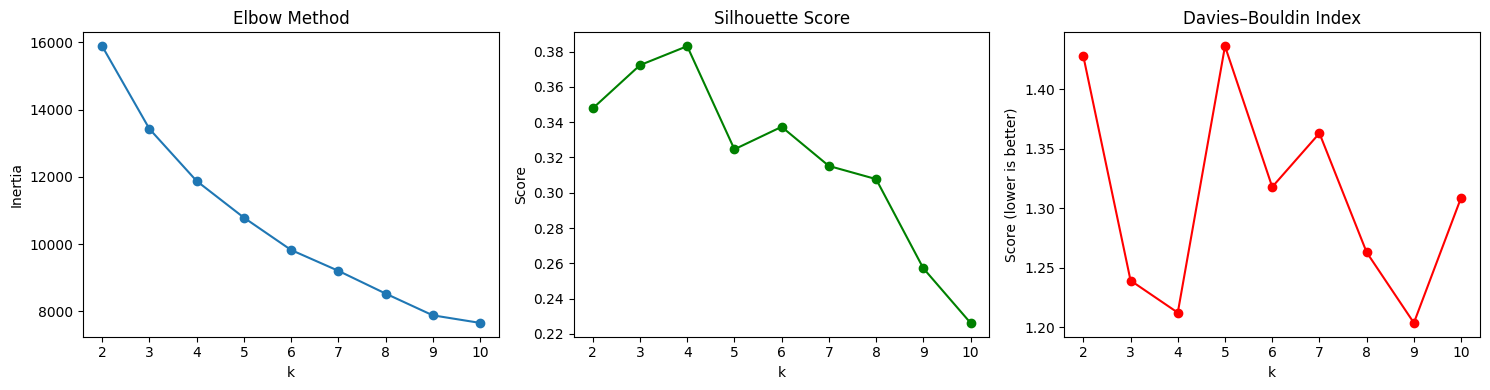

In [65]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

inertias = []
silhouettes = []
db_scores = []
K = range(2, 11)

for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    preds = model.fit_predict(famd_data)
    inertias.append(model.inertia_)
    silhouettes.append(silhouette_score(famd_data, preds))
    db_scores.append(davies_bouldin_score(famd_data, preds))


plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(K, inertias, 'o-')
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('Inertia')

plt.subplot(1, 3, 2)
plt.plot(K, silhouettes, 'o-', color='green')
plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('Score')

plt.subplot(1, 3, 3)
plt.plot(K, db_scores, 'o-', color='red')
plt.title('Davies–Bouldin Index')
plt.xlabel('k')
plt.ylabel('Score (lower is better)')

plt.tight_layout()
plt.show()



*  No clusters identified




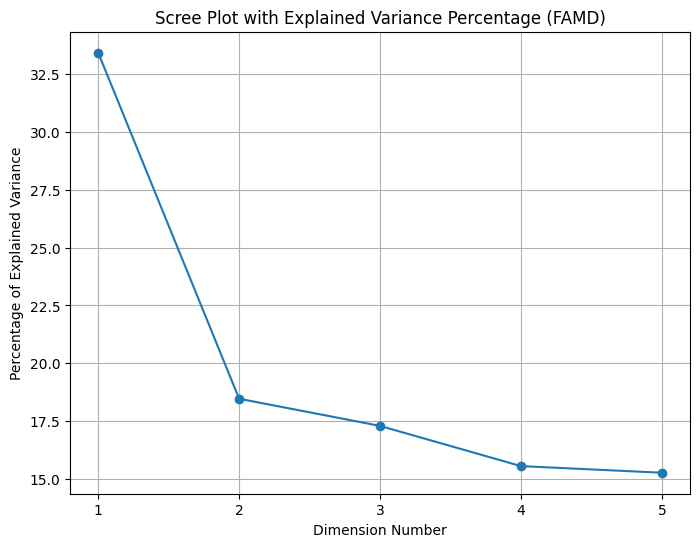

In [66]:
# 3. Extract eigenvalues
# Get eigenvalues and calculate explained variance percentage
eigenvalues = famd.eigenvalues_
explained_variance_ratio = (eigenvalues / eigenvalues.sum()) * 100

# Create the scree plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
plt.title('Scree Plot with Explained Variance Percentage (FAMD)')
plt.xlabel('Dimension Number')
plt.ylabel('Percentage of Explained Variance')
plt.grid(True)
plt.xticks(range(1, len(explained_variance_ratio) + 1)) # Ensure integer ticks
plt.show()

In [67]:
X_train.head()

,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate
598,23,140.0,90.0,6.8,98,23.0,0.0,0.0,0,0,70.0
186,28,140.0,90.0,8.0,98,25.7,0.0,1.0,0,1,80.0
762,25,120.0,90.0,6.7,101,21.0,0.0,0.0,0,0,80.0
180,25,130.0,100.0,7.8,98,30.6,0.0,0.0,1,1,86.0
604,19,120.0,80.0,4.0,98,20.0,0.0,0.0,0,0,70.0


In [68]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled.head()

,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate
0,-0.377313,1.219941,0.892273,-0.256307,-0.367228,-0.111078,-0.457792,-0.647160,-0.367027,-0.740279,-0.813628
1,-0.005723,1.219941,0.892273,0.136246,-0.367228,0.596154,-0.457792,1.545212,-0.367027,1.350842,0.560545
2,-0.228677,0.164668,0.892273,-0.289019,2.357838,-0.634954,-0.457792,-0.647160,-0.367027,-0.740279,0.560545
3,-0.228677,0.692304,1.588489,0.070820,-0.367228,1.879649,-0.457792,-0.647160,2.724596,1.350842,1.385048
4,-0.674586,0.164668,0.196057,-1.172263,-0.367228,-0.896892,-0.457792,-0.647160,-0.367027,-0.740279,-0.813628


In [69]:
y_train.value_counts()

Risk Level
Low     555
High    380
Name: count, dtype: int64

### Trying apply smote

In [70]:
# reduce class imbalance
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, k_neighbors=5)
x_train_smote, y_train_smote = smote.fit_resample(X_train,y_train)


print("Shape of original c1_x_train:", X_train.shape)
print("Shape of c1_y_train:",y_train.shape)
print("Shape of c1_x_train after scaling and SMOTE:", x_train_smote.shape)
print("Shape of c1_y_train after scaling and SMOTE:", y_train_smote.shape)
print("\nValue counts of original c1_y_train:")
print(y_train.value_counts())
print("\nValue counts of c1_y_train after SMOTE:")
print(y_train_smote.value_counts())

Shape of original c1_x_train: (935, 11)
Shape of c1_y_train: (935,)
Shape of c1_x_train after scaling and SMOTE: (1110, 11)
Shape of c1_y_train after scaling and SMOTE: (1110,)

Value counts of original c1_y_train:
Risk Level
Low     555
High    380
Name: count, dtype: int64

Value counts of c1_y_train after SMOTE:
Risk Level
Low     555
High    555
Name: count, dtype: int64


In [71]:
scaler_s = StandardScaler()
X_train_s_scaled = scaler_s.fit_transform(x_train_smote)
X_train_s_scaled = pd.DataFrame(X_train_s_scaled, columns=x_train_smote.columns)
X_train_s_scaled.head()

,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate
0,-0.395981,1.146085,0.816637,-0.343234,-0.377050,-0.196464,-0.531542,-0.753397,-0.370534,-0.775714,-0.878129
1,-0.006802,1.146085,0.816637,0.027183,-0.377050,0.490777,-0.531542,1.378204,-0.370534,1.289136,0.431103
2,-0.240309,0.118168,0.816637,-0.374102,2.323115,-0.705531,-0.531542,-0.753397,-0.370534,-0.775714,0.431103
3,-0.240309,0.632126,1.495740,-0.034553,-0.377050,1.737991,-0.531542,-0.753397,2.698811,1.289136,1.216643
4,-0.707324,0.118168,0.137534,-1.207539,-0.377050,-0.960064,-0.531542,-0.753397,-0.370534,-0.775714,-0.878129


X_train_scaled = preprocessing done , class imbalanced not handled<br>
X_train_s_scaled = preprocessing done , class imbalanced handled

In [72]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = pd.DataFrame(le.fit_transform(y_train.values.ravel()), columns=["Risk Level"])
y_train_smote_encoded = pd.DataFrame(le.transform(y_train_smote.values.ravel()), columns=["Risk Level"])

print(y_train_encoded.head())


   Risk Level
0           1
1           0
2           1
3           0
4           1


In [73]:
print("Original classes and their encoded values:")
for i, class_name in enumerate(le.classes_):
    print(f"{class_name}: {i}")

Original classes and their encoded values:
High: 0
Low: 1


### preprocessing of X_test

In [74]:
X_test.isnull().sum()

Age                       0
Systolic BP               0
Diastolic                 0
BS                        0
Body Temp                 0
BMI                       3
Previous Complications    0
Preexisting Diabetes      0
Gestational Diabetes      0
Mental Health             0
Heart Rate                0
dtype: int64

In [75]:

X_test['BMI'] = X_test['BMI'].fillna(X_train['BMI'].median())


print("Missing values in X_test after imputation:")
print(X_test.isnull().sum())

Missing values in X_test after imputation:
Age                       0
Systolic BP               0
Diastolic                 0
BS                        0
Body Temp                 0
BMI                       0
Previous Complications    0
Preexisting Diabetes      0
Gestational Diabetes      0
Mental Health             0
Heart Rate                0
dtype: int64


In [76]:
X_test.head()

,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate
712,18,120.0,80.0,5.9,102,18.9,0.0,0.0,0,0,76.0
1153,16,95.0,60.0,5.0,101,24.7,0.0,1.0,0,1,60.0
58,48,140.0,96.0,19.0,98,27.0,0.0,1.0,0,0,86.0
70,39,140.0,100.0,14.0,98,25.0,1.0,1.0,0,1,78.0
1066,21,90.0,60.0,6.9,102,24.4,0.0,1.0,1,0,77.0


In [77]:
X_test_scaled = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_test.head()

,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate
0,-0.992560,0.185497,0.178142,-0.443359,3.341216,-1.020331,-0.501335,-0.633402,-0.376116,-0.633402,0.037344
1,-1.217073,-1.207517,-1.227771,-0.732255,2.413761,0.394745,-0.501335,1.578777,-0.376116,1.578777,-2.217742
2,2.375139,1.299908,1.302873,3.761691,-0.368604,0.955896,-0.501335,1.578777,-0.376116,-0.633402,1.446773
3,1.364829,1.299908,1.584056,2.156710,-0.368604,0.467938,1.994674,1.578777,-0.376116,1.578777,0.319230
4,-0.655790,-1.486119,-1.227771,-0.122363,3.341216,0.321551,-0.501335,1.578777,2.658753,-0.633402,0.178287


In [78]:

y_test_encoded = pd.DataFrame(le.transform(y_test.values.ravel()), columns=["Risk Level"])
y_test_encoded.head()

,Risk Level
0,1
1,0
2,0
3,0
4,0


### Model Fitting

1. Ridge Regression

In [79]:
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression

ridge_model = RidgeClassifier()
ridge_model.fit(X_train_scaled, y_train_encoded)

# Predict on the trainign data
y_train_pred = ridge_model.predict(X_train_scaled)
y_test_pred = ridge_model.predict(X_test)

# Calculate classification accuracy on the training data
train_accuracy_lasso = accuracy_score(y_train_encoded,y_train_pred)
train_accuracy_lasso = accuracy_score(y_test_encoded,y_test_pred)

#print(f"Classification Accuracy on SMOTE Training Data (Lasso Regularized Logistic Regression): {train_accuracy_lasso:.4f}")

print("\nClassification Report on  Training Data (Lasso Regularized Logistic Regression):")
print(classification_report(y_train_encoded,y_train_pred))

print("\nClassification Report on Test Data (Lasso Regularized Logistic Regression):")
print(classification_report(y_test_encoded,y_test_pred))



Classification Report on  Training Data (Lasso Regularized Logistic Regression):
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       380
           1       0.96      0.98      0.97       555

    accuracy                           0.96       935
   macro avg       0.96      0.96      0.96       935
weighted avg       0.96      0.96      0.96       935


Classification Report on Test Data (Lasso Regularized Logistic Regression):
              precision    recall  f1-score   support

           0       0.96      0.97      0.96        93
           1       0.98      0.97      0.98       141

    accuracy                           0.97       234
   macro avg       0.97      0.97      0.97       234
weighted avg       0.97      0.97      0.97       234



In [80]:
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression

ridge_model = RidgeClassifier()
ridge_model.fit(X_train_s_scaled, y_train_smote_encoded)

# Predict on the trainign data
y_train_pred = ridge_model.predict(X_train_s_scaled)
y_test_pred = ridge_model.predict(X_test)

# Calculate classification accuracy on the training data
train_accuracy_lasso = accuracy_score(y_train_smote_encoded,y_train_pred)
train_accuracy_lasso = accuracy_score(y_test_encoded,y_test_pred)

#print(f"Classification Accuracy on SMOTE Training Data (Lasso Regularized Logistic Regression): {train_accuracy_lasso:.4f}")

print("\nClassification Report on  Training Data (Lasso Regularized Logistic Regression):")
print(classification_report(y_train_smote_encoded,y_train_pred))

print("\nClassification Report on Test Data (Lasso Regularized Logistic Regression):")
print(classification_report(y_test_encoded,y_test_pred))


Classification Report on  Training Data (Lasso Regularized Logistic Regression):
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       555
           1       0.93      0.97      0.95       555

    accuracy                           0.94      1110
   macro avg       0.94      0.94      0.94      1110
weighted avg       0.94      0.94      0.94      1110


Classification Report on Test Data (Lasso Regularized Logistic Regression):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        93
           1       0.99      0.97      0.98       141

    accuracy                           0.98       234
   macro avg       0.98      0.98      0.98       234
weighted avg       0.98      0.98      0.98       234



2. Lasso Regression

In [81]:
lasso_model = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42, max_iter=1000)
lasso_model.fit(X_train_scaled, y_train_encoded)

# Predict on the trainign data
y_train_pred_lasso = lasso_model.predict(X_train_scaled)
y_test_pred_lasso = lasso_model.predict(X_test)

# Calculate classification accuracy on the training data
train_accuracy_lasso = accuracy_score(y_train_encoded,y_train_pred_lasso)
train_accuracy_lasso = accuracy_score(y_test_encoded
                                      ,y_test_pred_lasso)

#print(f"Classification Accuracy on SMOTE Training Data (Lasso Regularized Logistic Regression): {train_accuracy_lasso:.4f}")

print("\nClassification Report on  Training Data (Lasso Regularized Logistic Regression):")
print(classification_report(y_train_encoded,y_train_pred_lasso))

print("\nClassification Report on Test Data (Lasso Regularized Logistic Regression):")
print(classification_report(y_test_encoded,y_test_pred_lasso))





Classification Report on  Training Data (Lasso Regularized Logistic Regression):
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       380
           1       0.97      0.97      0.97       555

    accuracy                           0.97       935
   macro avg       0.97      0.97      0.97       935
weighted avg       0.97      0.97      0.97       935


Classification Report on Test Data (Lasso Regularized Logistic Regression):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        93
           1       0.99      0.99      0.99       141

    accuracy                           0.98       234
   macro avg       0.98      0.98      0.98       234
weighted avg       0.98      0.98      0.98       234



In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define the parameter grid for tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],   # Regularization strength
    'solver': ['liblinear', 'saga'],  # solvers that support L1
    'max_iter': [500, 1000, 2000]     # iterations to ensure convergence
}

# Create Logistic Regression model
lasso_model = LogisticRegression(penalty='l1', random_state=42)

# Apply GridSearchCV
grid_search = GridSearchCV(
    estimator=lasso_model,
    param_grid=param_grid,
    cv=5,                # 5-fold cross-validation
    scoring='accuracy',  # metric for model selection
    n_jobs=-1            # use all CPU cores
)

# Fit grid search on training data
grid_search.fit(X_train_scaled, y_train_encoded.values.ravel())

# Best parameters and estimator
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Predictions
y_train_pred_lasso = best_model.predict(X_train_scaled)
y_test_pred_lasso = best_model.predict(X_test)

# Evaluation
train_accuracy = accuracy_score(y_train_encoded, y_train_pred_lasso)
test_accuracy = accuracy_score(y_test_encoded, y_test_pred_lasso)

print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

print("\nClassification Report on Training Data:")
print(classification_report(y_train_encoded, y_train_pred_lasso))

print("\nClassification Report on Test Data:")
print(classification_report(y_test_encoded, y_test_pred_lasso))


Best Parameters: {'C': 0.1, 'max_iter': 500, 'solver': 'liblinear'}

Training Accuracy: 0.9711
Test Accuracy: 0.9786

Classification Report on Training Data:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       380
           1       0.97      0.98      0.98       555

    accuracy                           0.97       935
   macro avg       0.97      0.97      0.97       935
weighted avg       0.97      0.97      0.97       935


Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        93
           1       0.99      0.98      0.98       141

    accuracy                           0.98       234
   macro avg       0.98      0.98      0.98       234
weighted avg       0.98      0.98      0.98       234



3. Naive Bayes

In [83]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
import warnings

clf =GaussianNB()
# Flatten y_train_encoded before fitting
clf.fit(X_train_scaled,y_train_encoded.values.ravel())


#Predict on the training data
y_train_pred = clf.predict(X_train_scaled)
y_test_pred = clf.predict(X_test)

# Calculate classification accuracy on the training data
train_accuracy = accuracy_score(y_train_encoded.values.ravel(),y_train_pred) # Flatten y_train_encoded for accuracy_score
test_accuracy= accuracy_score(y_test_encoded.values.ravel(),y_test_pred) # Flatten y_test_encoded for accuracy_score


print("\nClassification Report on  Training Data ")
print(train_accuracy)
print(classification_report(y_train_encoded,y_train_pred)) # Flatten y_train_encoded for classification_report

print("\nClassification Report on Test Data")
print(test_accuracy)
print(classification_report(y_test_encoded,y_test_pred)) # Flatten y_test_encoded for classification_report


warnings.filterwarnings('ignore')


Classification Report on  Training Data 
0.9497326203208556
              precision    recall  f1-score   support

           0       0.98      0.89      0.94       380
           1       0.93      0.99      0.96       555

    accuracy                           0.95       935
   macro avg       0.96      0.94      0.95       935
weighted avg       0.95      0.95      0.95       935


Classification Report on Test Data
0.3974358974358974
              precision    recall  f1-score   support

           0       0.40      1.00      0.57        93
           1       0.00      0.00      0.00       141

    accuracy                           0.40       234
   macro avg       0.20      0.50      0.28       234
weighted avg       0.16      0.40      0.23       234



In [84]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
import warnings

clf =GaussianNB()
# Flatten y_train_encoded before fitting
clf.fit(X_train_s_scaled,y_train_smote_encoded)


#Predict on the training data
y_train_pred = clf.predict(X_train_s_scaled)
y_test_pred = clf.predict(X_test)

# Calculate classification accuracy on the training data
train_accuracy = accuracy_score(y_train_smote_encoded.values.ravel(),y_train_pred) # Flatten y_train_encoded for accuracy_score
test_accuracy= accuracy_score(y_test_encoded.values.ravel(),y_test_pred) # Flatten y_test_encoded for accuracy_score


print("\nClassification Report on  Training Data ")
print(train_accuracy)
print(classification_report(y_train_smote_encoded.values.ravel(),y_train_pred)) # Flatten y_train_encoded for classification_report

print("\nClassification Report on Test Data")
print(test_accuracy)
print(classification_report(y_test_encoded.values.ravel(),y_test_pred)) # Flatten y_test_encoded for classification_report


warnings.filterwarnings('ignore')


Classification Report on  Training Data 
0.927027027027027
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       555
           1       0.88      0.98      0.93       555

    accuracy                           0.93      1110
   macro avg       0.93      0.93      0.93      1110
weighted avg       0.93      0.93      0.93      1110


Classification Report on Test Data
0.3974358974358974
              precision    recall  f1-score   support

           0       0.40      1.00      0.57        93
           1       0.00      0.00      0.00       141

    accuracy                           0.40       234
   macro avg       0.20      0.50      0.28       234
weighted avg       0.16      0.40      0.23       234



In [85]:


from sklearn.model_selection import GridSearchCV


# Define hyperparameter grid
param_grid = {
    'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1]
}

# GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit on training data
grid_search.fit(X_train_scaled, y_train_encoded)

# Best parameters & model
print("Best Parameters:", grid_search.best_params_)
best_clf = grid_search.best_estimator_

# Predictions
y_train_pred = best_clf.predict(X_train_scaled)
y_test_pred = best_clf.predict(X_test)

# Accuracy
train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)

print("\nClassification Report on Training Data")
print("Training Accuracy:", train_accuracy)
print(classification_report(y_train_encoded, y_train_pred))

print("\nClassification Report on Test Data")
print("Test Accuracy:", test_accuracy)
print(classification_report(y_test_encoded, y_test_pred))


Best Parameters: {'var_smoothing': 0.1}

Classification Report on Training Data
Training Accuracy: 0.9668449197860962
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       380
           1       0.97      0.97      0.97       555

    accuracy                           0.97       935
   macro avg       0.97      0.97      0.97       935
weighted avg       0.97      0.97      0.97       935


Classification Report on Test Data
Test Accuracy: 0.9786324786324786
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        93
           1       0.99      0.98      0.98       141

    accuracy                           0.98       234
   macro avg       0.98      0.98      0.98       234
weighted avg       0.98      0.98      0.98       234



### 4.  KNN

In [87]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

In [88]:
# for original data
knn_orig = KNeighborsClassifier()

grid_knn_orig = GridSearchCV(knn_orig,
                             param_grid_knn,
                             cv=5,
                             scoring='accuracy',
                             n_jobs=-1)

grid_knn_orig.fit(X_train_scaled, y_train_encoded.values.ravel())

print("Best parameters for original data KNN:", grid_knn_orig.best_params_)
print("Best CV accuracy for original data KNN:", grid_knn_orig.best_score_)


Best parameters for original data KNN: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}
Best CV accuracy for original data KNN: 0.976470588235294


In [89]:
y_pred_knn_orig = grid_knn_orig.predict(X_test)
print("Classification report for original test data KNN:")
print(classification_report(y_test_encoded, y_pred_knn_orig))
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred_knn_orig))

Classification report for original test data KNN:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        93
           1       0.99      0.96      0.97       141

    accuracy                           0.97       234
   macro avg       0.97      0.97      0.97       234
weighted avg       0.97      0.97      0.97       234

Confusion Matrix:
[[ 91   2]
 [  5 136]]


In [90]:
## for SMOTE data
knn_smote = KNeighborsClassifier()

grid_knn_smote = GridSearchCV(knn_smote,
                              param_grid_knn,
                              cv=5,
                              scoring='accuracy',
                              n_jobs=-1)

grid_knn_smote.fit(X_train_s_scaled, y_train_smote_encoded.values.ravel())

print("Best parameters for SMOTE data KNN:", grid_knn_smote.best_params_)
print("Best CV accuracy for SMOTE data KNN:", grid_knn_smote.best_score_)

Best parameters for SMOTE data KNN: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best CV accuracy for SMOTE data KNN: 0.9702702702702701


In [91]:
y_pred_knn_smote_train = grid_knn_smote.predict(X_train_s_scaled)
print("Classification report for SMOTE training data KNN:")
print(classification_report(y_train_smote_encoded, y_pred_knn_smote_train))
print("Confusion Matrix:")
print(confusion_matrix(y_train_smote_encoded, y_pred_knn_smote_train))

Classification report for SMOTE training data KNN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       555
           1       1.00      1.00      1.00       555

    accuracy                           1.00      1110
   macro avg       1.00      1.00      1.00      1110
weighted avg       1.00      1.00      1.00      1110

Confusion Matrix:
[[555   0]
 [  0 555]]


In [92]:
y_pred_knn_orig_train = grid_knn_orig.predict(X_train_scaled)
print("Classification report for original training data KNN:")
print(classification_report(y_train_encoded, y_pred_knn_orig_train))
print("Confusion Matrix:")
print(confusion_matrix(y_train_encoded, y_pred_knn_orig_train))

Classification report for original training data KNN:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       380
           1       0.99      0.99      0.99       555

    accuracy                           0.99       935
   macro avg       0.99      0.99      0.99       935
weighted avg       0.99      0.99      0.99       935

Confusion Matrix:
[[374   6]
 [  5 550]]


In [93]:
y_pred_knn_smote = grid_knn_smote.predict(X_test)
print("Classification report for SMOTE test data KNN:")
print(classification_report(y_test_encoded, y_pred_knn_smote))
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred_knn_smote))

Classification report for SMOTE test data KNN:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        93
           1       0.99      0.96      0.98       141

    accuracy                           0.97       234
   macro avg       0.97      0.98      0.97       234
weighted avg       0.98      0.97      0.97       234

Confusion Matrix:
[[ 92   1]
 [  5 136]]


### 5. SVM

In [94]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}


In [95]:

# Fit SVM on original data

svm_orig = SVC(random_state=42)

grid_orig = GridSearchCV(svm_orig, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_orig.fit(X_train_scaled, y_train_encoded.values.ravel())

print("Best parameters for original data:", grid_orig.best_params_)
print("Best CV accuracy for original data:", grid_orig.best_score_)

# Predictions and evaluation

# On training data
y_pred_orig_train = grid_orig.predict(X_train_scaled)
print("\nClassification report for original training data:")
print(classification_report(y_train_encoded, y_pred_orig_train))
print("Confusion Matrix:")
print(confusion_matrix(y_train_encoded, y_pred_orig_train))

# On test data
y_pred_orig = grid_orig.predict(X_test)
print("\nClassification report for original test data:")
print(classification_report(y_test_encoded, y_pred_orig))
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred_orig))

Best parameters for original data: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV accuracy for original data: 0.9764705882352942

Classification report for original training data:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       380
           1       0.99      1.00      1.00       555

    accuracy                           1.00       935
   macro avg       1.00      1.00      1.00       935
weighted avg       1.00      1.00      1.00       935

Confusion Matrix:
[[377   3]
 [  1 554]]

Classification report for original test data:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        93
           1       0.99      0.96      0.98       141

    accuracy                           0.97       234
   macro avg       0.97      0.98      0.97       234
weighted avg       0.98      0.97      0.97       234

Confusion Matrix:
[[ 92   1]
 [  5 136]]


In [96]:

# Fit SVM on SMOTE data

svm_smote = SVC(random_state=42)

grid_smote = GridSearchCV(svm_smote, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_smote.fit(X_train_s_scaled, y_train_smote_encoded.values.ravel())

print("\nBest parameters for SMOTE data:", grid_smote.best_params_)
print("Best CV accuracy for SMOTE data:", grid_smote.best_score_)

# Predictions and evaluation

# On training data (use SMOTE-balanced set)
y_pred_smote_train = grid_smote.predict(X_train_s_scaled)
print("\nClassification report for SMOTE training data:")
print(classification_report(y_train_smote_encoded, y_pred_smote_train))
print("Confusion Matrix:")
print(confusion_matrix(y_train_smote_encoded, y_pred_smote_train))

# On test data
y_pred_smote = grid_smote.predict(X_test)
print("\nClassification report for SMOTE testing data:")
print(classification_report(y_test_encoded, y_pred_smote))
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred_smote))


Best parameters for SMOTE data: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV accuracy for SMOTE data: 0.9693693693693695

Classification report for SMOTE training data:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       555
           1       1.00      0.99      1.00       555

    accuracy                           1.00      1110
   macro avg       1.00      1.00      1.00      1110
weighted avg       1.00      1.00      1.00      1110

Confusion Matrix:
[[554   1]
 [  3 552]]

Classification report for SMOTE testing data:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96        93
           1       0.99      0.96      0.97       141

    accuracy                           0.97       234
   macro avg       0.97      0.97      0.97       234
weighted avg       0.97      0.97      0.97       234

Confusion Matrix:
[[ 92   1]
 [  6 135]]


### Random Forest 

In [97]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}


In [98]:

# Fit Random Forest on original data

rf_orig = RandomForestClassifier(random_state=42)

grid_rf_orig = GridSearchCV(rf_orig, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf_orig.fit(X_train_scaled, y_train_encoded.values.ravel())

print("Best parameters for original data RF:", grid_rf_orig.best_params_)
print("Best CV accuracy for original data RF:", grid_rf_orig.best_score_)

# Predictions and evaluation

# On training data
y_pred_rf_orig_train = grid_rf_orig.predict(X_train_scaled)
print("\nClassification report for original training data RF:")
print(classification_report(y_train_encoded, y_pred_rf_orig_train))
print("Confusion Matrix:")
print(confusion_matrix(y_train_encoded, y_pred_rf_orig_train))

# On test data
y_pred_rf_orig = grid_rf_orig.predict(X_test)
print("\nClassification report for original test data RF:")
print(classification_report(y_test_encoded, y_pred_rf_orig))
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred_rf_orig))

Best parameters for original data RF: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV accuracy for original data RF: 0.990374331550802

Classification report for original training data RF:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       380
           1       1.00      1.00      1.00       555

    accuracy                           1.00       935
   macro avg       1.00      1.00      1.00       935
weighted avg       1.00      1.00      1.00       935

Confusion Matrix:
[[380   0]
 [  0 555]]

Classification report for original test data RF:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        93
           1       0.99      0.97      0.98       141

    accuracy                           0.98       234
   macro avg       0.98      0.98      0.98       234
weighted avg       0.98      0.98      0.98       2

In [99]:

# Fit Random Forest on SMOTE data

rf_smote = RandomForestClassifier(random_state=42)

grid_rf_smote = GridSearchCV(rf_smote, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf_smote.fit(X_train_s_scaled, y_train_smote_encoded.values.ravel())

print("\nBest parameters for SMOTE data RF:", grid_rf_smote.best_params_)
print("Best CV accuracy for SMOTE data RF:", grid_rf_smote.best_score_)

# Predictions and evaluation

# On training (SMOTE) data
y_pred_rf_smote_train = grid_rf_smote.predict(X_train_s_scaled)
print("\nClassification report for SMOTE training data RF:")
print(classification_report(y_train_smote_encoded, y_pred_rf_smote_train))
print("Confusion Matrix:")
print(confusion_matrix(y_train_smote_encoded, y_pred_rf_smote_train))

# On test data
y_pred_rf_smote = grid_rf_smote.predict(X_test)
print("\nClassification report for SMOTE test data RF:")
print(classification_report(y_test_encoded, y_pred_rf_smote))
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred_rf_smote))


Best parameters for SMOTE data RF: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best CV accuracy for SMOTE data RF: 0.9873873873873874

Classification report for SMOTE training data RF:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       555
           1       1.00      1.00      1.00       555

    accuracy                           1.00      1110
   macro avg       1.00      1.00      1.00      1110
weighted avg       1.00      1.00      1.00      1110

Confusion Matrix:
[[555   0]
 [  0 555]]

Classification report for SMOTE test data RF:
              precision    recall  f1-score   support

           0       0.56      1.00      0.72        93
           1       1.00      0.48      0.64       141

    accuracy                           0.68       234
   macro avg       0.78      0.74      0.68       234
weighted avg       0.82      0.68      0.67       234

Confus

### XGBoost 

In [100]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define hyperparameter grid for XGBoost

param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

In [101]:

# Fit XGBoost on original data

xgb_orig = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

grid_xgb_orig = GridSearchCV(xgb_orig, param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1)
grid_xgb_orig.fit(X_train_scaled, y_train_encoded.values.ravel())

print("Best parameters for original data XGBoost:", grid_xgb_orig.best_params_)
print("Best CV accuracy for original data XGBoost:", grid_xgb_orig.best_score_)

# Predictions and evaluation

# On training data
y_pred_xgb_orig_train = grid_xgb_orig.predict(X_train_scaled)
print("\nClassification report for original training data XGBoost:")
print(classification_report(y_train_encoded, y_pred_xgb_orig_train))
print("Confusion Matrix:")
print(confusion_matrix(y_train_encoded, y_pred_xgb_orig_train))

# On test data
y_pred_xgb_orig = grid_xgb_orig.predict(X_test)
print("\nClassification report for original test data XGBoost:")
print(classification_report(y_test_encoded, y_pred_xgb_orig))
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred_xgb_orig))

Best parameters for original data XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}
Best CV accuracy for original data XGBoost: 0.9935828877005347

Classification report for original training data XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       380
           1       1.00      1.00      1.00       555

    accuracy                           1.00       935
   macro avg       1.00      1.00      1.00       935
weighted avg       1.00      1.00      1.00       935

Confusion Matrix:
[[380   0]
 [  0 555]]

Classification report for original test data XGBoost:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        93
           1       0.96      0.99      0.97       141

    accuracy                           0.97       234
   macro avg       0.97      0.96      0.96       234
weighted avg       0.97      0.97    

In [102]:

# Fit XGBoost on SMOTE data

xgb_smote = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

grid_xgb_smote = GridSearchCV(xgb_smote, param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1)
grid_xgb_smote.fit(X_train_s_scaled, y_train_smote_encoded.values.ravel())

print("\nBest parameters for SMOTE data XGBoost:", grid_xgb_smote.best_params_)
print("Best CV accuracy for SMOTE data XGBoost:", grid_xgb_smote.best_score_)

# Predictions and evaluation

# On training (SMOTE) data
y_pred_xgb_smote_train = grid_xgb_smote.predict(X_train_s_scaled)
print("\nClassification report for SMOTE training data XGBoost:")
print(classification_report(y_train_smote_encoded, y_pred_xgb_smote_train))
print("Confusion Matrix:")
print(confusion_matrix(y_train_smote_encoded, y_pred_xgb_smote_train))

# On test data
y_pred_xgb_smote = grid_xgb_smote.predict(X_test)
print("\nClassification report for SMOTE test data XGBoost:")
print(classification_report(y_test_encoded, y_pred_xgb_smote))
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred_xgb_smote))


Best parameters for SMOTE data XGBoost: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}
Best CV accuracy for SMOTE data XGBoost: 0.990990990990991

Classification report for SMOTE training data XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       555
           1       1.00      1.00      1.00       555

    accuracy                           1.00      1110
   macro avg       1.00      1.00      1.00      1110
weighted avg       1.00      1.00      1.00      1110

Confusion Matrix:
[[555   0]
 [  0 555]]

Classification report for SMOTE test data XGBoost:
              precision    recall  f1-score   support

           0       0.46      0.99      0.63        93
           1       0.97      0.23      0.38       141

    accuracy                           0.53       234
   macro avg       0.72      0.61      0.50       234
weighted avg       0.77      0.53      0.48      

## Stacking 

#### RF
- train acc=0.96
- test acc=0.95
#### SVM
- train acc=0.98
- test acc=0.97
#### lasso
- train acc=0.97
- test acc=0.98

#### combine RF + SVM as base learners and use Lasso as the meta (final) model

In [103]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Base models
rf = RandomForestClassifier(
    n_estimators=50, max_depth=2, min_samples_split=2,
    min_samples_leaf=1, max_features='sqrt', random_state=42
)

svm = Pipeline([
    ('scaler', StandardScaler()),   
    ('svm', SVC(C=1, kernel='rbf', gamma='scale', probability=True, random_state=42))
])

# Final estimator (Lasso Logistic Regression)
lasso_final = LogisticRegression(
    penalty='l1', solver='liblinear', C=1.0, random_state=42, max_iter=1000
)

# Build stacking classifier
stack_clf = StackingClassifier(
    estimators=[('rf', rf), ('svm', svm)],
    final_estimator=lasso_final,
    cv=5,
    n_jobs=-1,
    passthrough=False   # set True if you want to include original features too
)

# Fit on training data (use your preprocessed X_train, y_train)
stack_clf.fit(X_train_scaled, y_train_encoded.values.ravel())

# Predictions
y_pred_train = stack_clf.predict(X_train_scaled)
y_pred_test = stack_clf.predict(X_test)

# Evaluation
print("\nClassification Report (Train - Stacking):")
print(classification_report(y_train_encoded, y_pred_train))

print("\nClassification Report (Test - Stacking):")
print(classification_report(y_test_encoded, y_pred_test))

print("Confusion Matrix (Test - Stacking):")
print(confusion_matrix(y_test_encoded, y_pred_test))


Classification Report (Train - Stacking):
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       380
           1       0.99      0.98      0.98       555

    accuracy                           0.98       935
   macro avg       0.98      0.98      0.98       935
weighted avg       0.98      0.98      0.98       935


Classification Report (Test - Stacking):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        93
           1       0.99      0.98      0.99       141

    accuracy                           0.98       234
   macro avg       0.98      0.98      0.98       234
weighted avg       0.98      0.98      0.98       234

Confusion Matrix (Test - Stacking):
[[ 92   1]
 [  3 138]]


### ---------------------------------------------- END ----------------------------------------------------------------------------